# Working with sequences 

## Sequence to sequence example in Keras. (adapted from [Keras Blog](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html))

In [1]:
import os

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Imports and parameters

In [49]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense, CuDNNLSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import RMSprop
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [124]:
batch_size = 128  # Batch size for training.
epochs = 30  # Number of epochs to train for.
latent_dim = 512  # Latent dimensionality of the encoding space.
num_samples = 100000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'heb-eng/heb.txt'
# data_path = 'ell-eng/ell.txt'

### Vectorize the data and prepare training/test sets.

We will turn the sentences into three Numpy arrays: encoder_input_data, decoder_input_data, decoder_target_data.

**encoder_input_data** is a 3D array of shape (num_pairs, max_english_sentence_length, num_english_characters) containing a one-hot vectorization of the English sentences.

**decoder_input_data** is a 3D array of shape (num_pairs, max_french_sentence_length, num_french_characters) containg a one-hot vectorization of the Hebrew sentences.

**decoder_target_data** is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :].

In [91]:
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [92]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 100000
Number of unique input tokens: 83
Number of unique output tokens: 104
Max sequence length for inputs: 38
Max sequence length for outputs: 64


In [93]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [94]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [117]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

### Build the model

In [109]:
from keras import regularizers as rglz
from keras.layers import Bidirectional

In [112]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = CuDNNLSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = CuDNNLSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', kernel_regularizer=rglz.l2(0.01))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [113]:
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

In [125]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[EarlyStopping(patience=3, verbose=1), ReduceLROnPlateau(patience=1, min_lr=10e-6, verbose=1)],
          validation_split=0.2)

Train on 80000 samples, validate on 20000 samples
Epoch 1/30
80000/80000 [==============================] - 30s 379us/step - loss: 0.4568 - val_loss: 0.7595
Epoch 2/30
80000/80000 [==============================] - 29s 363us/step - loss: 0.4559 - val_loss: 0.7589
Epoch 3/30
80000/80000 [==============================] - 29s 358us/step - loss: 0.4551 - val_loss: 0.7590
Epoch 4/30
80000/80000 [==============================] - 28s 350us/step - loss: 0.4544 - val_loss: 0.7592

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 5/30
80000/80000 [==============================] - 30s 370us/step - loss: 0.4528 - val_loss: 0.7592

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 00005: early stopping


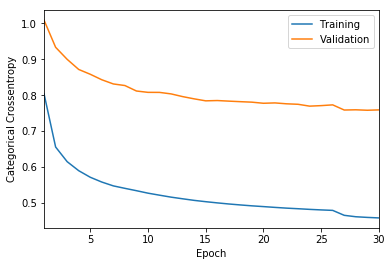

In [115]:
history = model.history
fig, ax = plt.subplots(1, 1)
ax.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label='Training')
ax.plot(range(1, len(history.history['loss'])+1), history.history['val_loss'], label='Validation')
ax.legend(loc='upper right')
ax.set_xlim(1, epochs)
ax.set_xlabel('Epoch')
ax.set_ylabel('Categorical Crossentropy')
plt.show()

In [116]:
# Save model
model.save('s2s_eng_%s_30e_LSTM_512_reg.h5' % (data_path.split('/')[-1].rstrip('.txt')))

/home/thras/.pyenv/versions/3.5.2/envs/structural-comet-py352/lib/python3.5/site-packages/keras/engine/topology.py:2364: UserWarning: Layer cu_dnnlstm_12 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_11/strided_slice_16:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'cu_dnnlstm_11/strided_slice_17:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


### inference mode (sampling).
Here's the drill:
1) encode input and retrieve initial decoder state
2) run one step of decoder with this initial state and a "start of sequence" token as target.Output will be the next target token
3) Repeat with the current target token and current states

In [126]:
def decode_sequence(input_seq, encoder_model, decoder_model):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [127]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [128]:
test_texts_1 = ['Thanks.', 'Hello.', 'How are you?']

In [129]:
test_texts_2 = [input_texts[i] for i in random.sample(range(len(input_texts)), 10)]

In [130]:
def encode_texts_to_1hot_seq(input_texts):
    input_seq = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
    for i, text in enumerate(input_texts):
        for t, char in enumerate(text):
            input_seq[i, t, input_token_index[char]] = 1.
    return input_seq

In [131]:
for test_text in test_texts_1:
    # Take one sequence (part of the training set) for trying out decoding.
    input_seq = encode_texts_to_1hot_seq([test_text])
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model)
    print('-')
    print('Input sentence:', test_text)
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Thanks.
Decoded sentence: תודה שלא.

-
Input sentence: Hello.
Decoded sentence: היים מודרים.

-
Input sentence: How are you?
Decoded sentence: איך אתה מרייה?



In [133]:
for test_text in test_texts_2:
    # Take one sequence (part of the training set) for trying out decoding.
    input_seq = encode_texts_to_1hot_seq([test_text])
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model)
    print('-')
    print('Input sentence:', test_text)
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: It's hard to resist temptation.
Decoded sentence: זה משוח מאוד מהרים.

-
Input sentence: These are nice.
Decoded sentence: אלה הביתי.

-
Input sentence: Am I wasting my time?
Decoded sentence: אני מוכנה להיות מאושר?

-
Input sentence: Will you leave a message?
Decoded sentence: תוכל להתיי בתום?

-
Input sentence: I'm a late riser.
Decoded sentence: אני מאושר מאוד.

-
Input sentence: You should stay.
Decoded sentence: אתה מריי הרבה.

-
Input sentence: You may as well leave now.
Decoded sentence: אתה יכול להיות מה שאני יודע.

-
Input sentence: I pretended to be asleep.
Decoded sentence: התחלתי להתיישר לא.

-
Input sentence: Tom has some things to take care of.
Decoded sentence: לתום יש משהו מאוד מהר.

-
Input sentence: I'm so happy.
Decoded sentence: אני מאוד מאושרת.



## Biological Sequences: DNA and proteins

In [3]:
import evolutron.tools as et

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

### Transforming the protein sequence into an 1-hot representation

In [37]:
amino_acids = list(et.aa_map.keys())

In [51]:
aa_seq = 'MASGKFITFEGIDGAGKTTHLQWFCERLQAKLAAGGRQVVVTREPGGTQLGEKLREILLN QPMDLETEAL LMFAARREHL ALVIEPALAR GDWVVSDRFT DATFAYQGGG RGLPRDKLET LERWVQGGFQ PDLTVLFDVA PQVASERRGA VRMPDKFESE SDAFFSRTRG EYLRRAEEAP HRFAIVDATQ SIPEIRQQLE RVLAAL'.replace(' ','')
aa_hot = et.aa2hot(aa_seq)

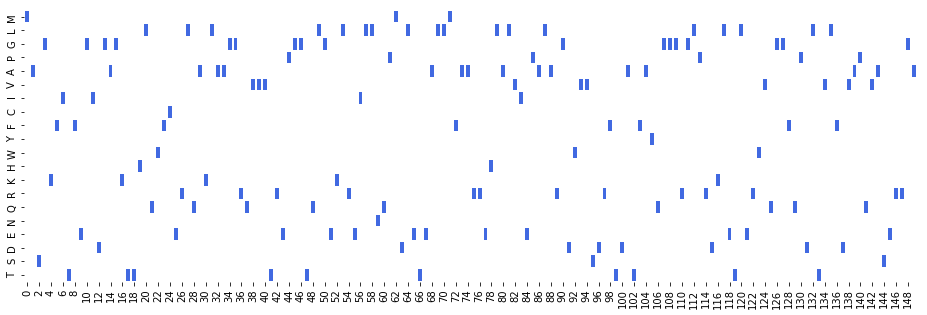

In [54]:
fig, ax = plt.subplots(1,1, figsize=(16,5)) 
sns.heatmap(aa_hot.T, ax=ax, yticklabels=amino_acids, linewidths=1, cmap=['white', 'royalblue'], cbar=False)
plt.show()

In [40]:
dna_seq = 'GTAYGGGRTN'
dna_hot = et.nt2prob(dna_seq)

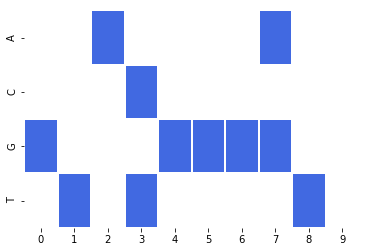

In [42]:
fig, ax = plt.subplots(1,1) 
sns.heatmap(dna_hot.T, ax=ax, yticklabels=['A','C','G','T'], linewidths=1, cmap=['white', 'royalblue'], cbar=False)
plt.show()